## What is Cointegration?
Unlike correlation, cointegration checks whether two non-stationary time series share a **stable long-term relationship.

Two series Xₜ and Yₜ are cointegrated if there exists a coefficient **β** such that the spread:

**Zₜ = Yₜ − β·Xₜ is stationary** (I(0)): it has constant mean and variance, no trend, and it reverts to its mean. And if X and Y are not stationnary

This property enables **pairs trading** — betting that the spread will return to equilibrium.

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
import statsmodels.api as sm

Matplotlib is building the font cache; this may take a moment.


# Exemple

In [3]:
tickers = ['XOM','CVX'] #ExxonMobil et chevron (compagnie pétrolière)

data = yf.download(tickers, start = "2015-01-01", end = "2025-12-31")['Close']
data = data.dropna() #remove missing value
data


C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\1731743729.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = "2015-01-01", end = "2025-12-31")['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,CVX,XOM
Date,,
2015-01-02,70.209549,57.916901
2015-01-05,67.403168,56.332172
2015-01-06,67.371986,56.032711
2015-01-07,67.315865,56.600479
2015-01-08,68.856270,57.542572
...,...,...
2025-11-28,151.130005,115.919998
2025-12-01,152.539993,116.629997
2025-12-02,150.250000,115.379997


<function matplotlib.pyplot.show(close=None, block=None)>

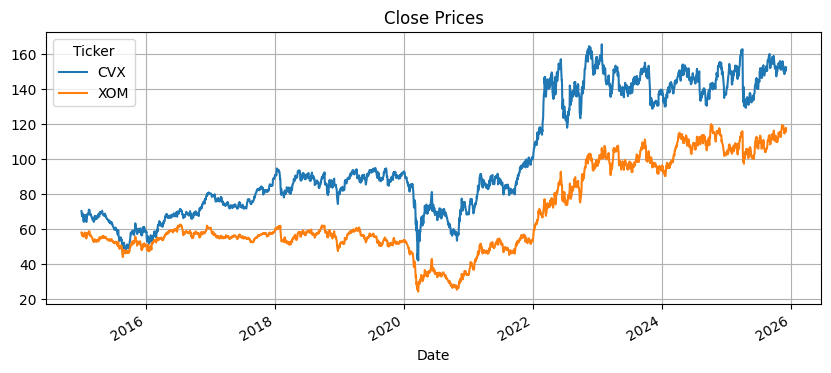

In [4]:
data.plot(figsize=(10,4),title="Close Prices")
plt.grid(True)
plt.show

Test that Zt is stationnary but Y and X not (necessary for cointegration) ; ADF test

## What is a Unit Root?

A time series has a **unit root** if it follows a random walk and is **non-stationary.**

Consider an AR(1) process:

**yₜ = ρ·yₜ₋₁ + εₜ

- If **|ρ| < 1** → the series is **stationary**
- If **ρ = 1** → the series has a **unit root** → it's a **random walk**

In that case:

**yₜ = yₜ₋₁ + εₜ

The process **does not revert to a mean**, and shocks have **permanent effects.**
This is why detecting a unit root (e.g. via the ADF test) is crucial for cointegration analysis.

The **Augmented Dickey-Fuller (ADF) test** checks for the presence of a **unit root.

It runs a regression like: **Δyₜ = α + γ·yₜ₋₁ + ϕ₁·Δyₜ₋₁ + ... + ϕₚ·Δyₜ₋ₚ + εₜ

and tests:

- **H₀**: γ = 0 → the series has a unit root (non-stationary)
- **H₁**: γ < 0 → the series is stationary

If the p-value < 0.05, we reject H₀:

→ the series does not have a unit root → it is stationary.

This is key for cointegration:
we test whether the residual spread **Zₜ = Yₜ − β·X**ₜ is stationary using ADF.


In [5]:
# we'll use ADF test to verify that series are individually not stationnary

for ticker in data.columns:
    result = adfuller(data[ticker])
    print(f"{ticker}ADF p-value: {result[1]:.4f}")

CVXADF p-value: 0.7316
XOMADF p-value: 0.9080


For both p value is high we accept H0

# Step 1: Understanding Cointegration
We want to determine if two non-stationary time series Xₜ and Yₜ share a stable long-term relationship.
This happens if there exists a coefficient β such that the spread Zₜ = Yₜ - β Xₜ is **stationary** (i.e., Zₜ ~ I(0)).

# How do we find β?
We use linear regression:

Yₜ = β Xₜ + εₜ
Then: Zₜ = εₜ = Yₜ - β Xₜ

If the residuals Zₜ are stationary (tested via ADF), then Xₜ and Yₜ are **cointegrated.**

In [6]:
x = data['XOM']
y = data['CVX']
X = sm.add_constant(x) # addintercept

model = sm.OLS(y,X).fit() # regrssion linéaire

Z = model.resid

In [7]:
# Test if Z is stationnary
adf_result = adfuller(Z)

print(f"p-value: {adf_result[1]}")

p-value: 0.1368941431332586


In [8]:
import numpy as np
x = np.log(data['XOM'])
y = np.log(data['CVX'])

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
z = model.resid

from statsmodels.tsa.stattools import adfuller
print(adfuller(z)[1])  # nouvelle p-value

0.2721291197938904


The p_value is too high we can continue with this 2 series

In [9]:
from itertools import combinations

# Let's take several ticker and practice ADF to see if there are 2 cointegrated series 

tickers = ['CVX', 'XOM', 'BP', 'TTE', 'SHEL']  # gas company 


data = yf.download(tickers, start="2015-01-01", end="2025-12-31")['Close']


data = data.dropna() 
log_prices = np.log(data)

results = []



C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\3308976127.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2025-12-31")['Close']
[*********************100%***********************]  5 of 5 completed


In [10]:
# we'll use ADF test to verify that series are individually not stationnary

for ticker in data.columns:
    result = adfuller(data[ticker])
    print(f"{ticker}ADF p-value: {result[1]:.4f}")

BPADF p-value: 0.3888
CVXADF p-value: 0.7316
SHELADF p-value: 0.8616
TTEADF p-value: 0.8818
XOMADF p-value: 0.9080


p value is superior to 0.05 we accept H0, the series are non-stationnary only for CVXADF - SHELADF - TTEADF - XOMADF

In [11]:
# test Z for severals pairs of stocks 
for t1, t2 in combinations(log_prices.columns, 2):
    y = log_prices[t1]
    x = log_prices[t2]
    x_ = sm.add_constant(x)
    model = sm.OLS(y, x_).fit()
    beta = model.params[1]
    residuals = model.resid
    pval = adfuller(residuals)[1]
    
    results.append({'pair': (t1, t2), 'beta': beta, 'p-value': pval})

# Résultats triés par p-value
result_df = pd.DataFrame(results).sort_values('p-value')
print(result_df)

C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\

          pair      beta   p-value
5   (CVX, TTE)  1.049198  0.004278
1   (BP, SHEL)  0.748987  0.004583
7  (SHEL, TTE)  0.905681  0.111369
3    (BP, XOM)  0.522935  0.126286
2    (BP, TTE)  0.663391  0.137785
0    (BP, CVX)  0.573716  0.142536
9   (TTE, XOM)  0.735347  0.165155
4  (CVX, SHEL)  0.995806  0.173117
6   (CVX, XOM)  0.812434  0.272130
8  (SHEL, XOM)  0.721073  0.335127


C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


From the result we can see that Total and Chevron represent a cointegration let's continue with theses 2 assets to continue

In [12]:
import numpy as np
x = np.log(data['TTE'])
y = np.log(data['CVX'])

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
Z = model.resid

print(adfuller(Z)[1]) 

0.004278049856826288


P value < 0.05 H0 is rejected Z is stationnary we have found our good candidates

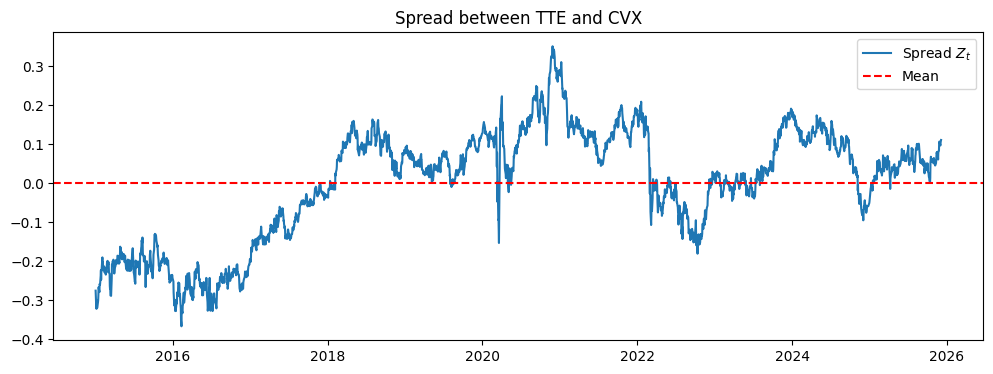

In [13]:
# Let's make sure there is a mean reversion occurs 

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Spread $Z_t$')
plt.axhline(residuals.mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread between TTE and CVX')
plt.legend()
plt.show()

# Practice 

We took a timeline of 9 years, it's too long.

1. On the commodities the price depend of : 

- Weather
- Production / harvests
- Stocks (inventories)
- Geopolitical tensions
- Seasonality
- Transportation costs
- Logistical conditions
- Short-term demand cycles

So a cointegration relation is rarely stable on 1 year or more.
A short window = we capture the current relationship, not an outdated one from the past.

2. Commodity spreads have a short half-life

In statistics, the half-life measures how long a spread takes to revert to its mean.

Spreads between commodities (e.g., crack spread, spark spread, intra-energy spreads, etc.) often have a short half-life: from a few days to a few weeks.

So analyzing one year of data:

- dilutes the signal
- mixes different regimes
- and destroys stationarity
📌 → 1 à 3 month --> enough

3. Regimes shift very quickly in commodities

Commodities often switch structural regimes:

- hurricane → supply shock → change in relationships
- OPEC announcement → shift in oil
- drought → shift in wheat/corn
- high inventories → prices under pressure
- change in contango/backwardation → new dynamics
- These changes create structural breaks in cointegration.

The shorter the window, the fewer structural breaks you include.

4. Professional traders use fast-reacting models

In commodity trading desks, traders:
- recalibrate their models frequently
- use very short lookback periods
- update their spreads (e.g., 3-2-1 crack spread) daily

Quant funds do the same:
- 20–60-day windows = standard
- 12 months = far too long → unstable cointegration

5. Why not 6 or 12 months?

Because after 6 months:
- seasonality changes
- transportation costs change
- seasonal buying/selling patterns change
- inventories are no longer the same
- the futures market changes structurally

So your cointegration tests might be valid at one point… but no longer valid now.

The relationship would be wrong.

### Conclusion 

What window should you use in practice?

Quant desks use:

⭐ A calibration window between 6 months and 2 years
→ rarely more, never 10 years.

- For equities: 6–12 months
- For FX: 1–2 years max
- **For futures/commodities: 3–9 months**

Why?
Because the economic relationship between two assets evolves.


In [14]:
from itertools import combinations

# Let's take several ticker and practice ADF to see if there are 2 cointegrated series 

tickers = ['CVX', 'XOM', 'BP', 'TTE', 'SHEL']  # gas company 


data = yf.download(tickers, start="2025-08-24", end="2025-11-29")
data = yf.download(
    tickers,
    start="2025-08-24",
    end="2025-12-04",
    auto_adjust=True  # <-- très important
)['Close']           # <-- ces Close sont déjà "Adj Close"
data = data.dropna() 
log_prices = np.log(data)

results = []

C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\1582383372.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2025-08-24", end="2025-11-29")
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


In [15]:
# we'll use ADF test to verify that series are individually not stationnary

for ticker in data.columns:
    result = adfuller(data[ticker])
    print(f"{ticker}ADF p-value: {result[1]:.4f}")

BPADF p-value: 0.8411
CVXADF p-value: 0.0623
SHELADF p-value: 0.4373
TTEADF p-value: 0.9354
XOMADF p-value: 0.2962


p value is superior to 0.05 we accept H0, the series are non-stationnary only for all

In [16]:
# test Z for severals pairs of stocks 
for t1, t2 in combinations(log_prices.columns, 2):
    y = log_prices[t1]
    x = log_prices[t2]
    x_ = sm.add_constant(x)
    model = sm.OLS(y, x_).fit()
    beta = model.params[1]
    residuals = model.resid
    pval = adfuller(residuals)[1]
    
    results.append({'pair': (t1, t2), 'beta': beta, 'p-value': pval})

# Résultats triés par p-value
result_df = pd.DataFrame(results).sort_values('p-value')
print(result_df)

          pair      beta   p-value
2    (BP, TTE)  0.835948  0.008893
4  (CVX, SHEL) -0.059430  0.045242
5   (CVX, TTE) -0.045941  0.046848
7  (SHEL, TTE)  0.444051  0.048492
6   (CVX, XOM)  0.004728  0.063869
3    (BP, XOM)  1.291706  0.074498
8  (SHEL, XOM)  0.757710  0.114914
9   (TTE, XOM)  1.185710  0.147589
1   (BP, SHEL)  1.147038  0.729355
0    (BP, CVX) -0.018741  0.815374


C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\Local\Temp\ipykernel_17580\936661517.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Jelaiel\AppData\

From the result we can see that Total and BP represent a cointegration let's continue with theses BP TTE best results

In [17]:
import numpy as np
x = np.log(data['TTE'])
y = np.log(data['BP'])

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
Z = model.resid

print(adfuller(Z)[1]) 

0.00889330358898675


P value < 0.05 H0 is rejected Z is stationnary we have found our good candidates with good timeline/horizon

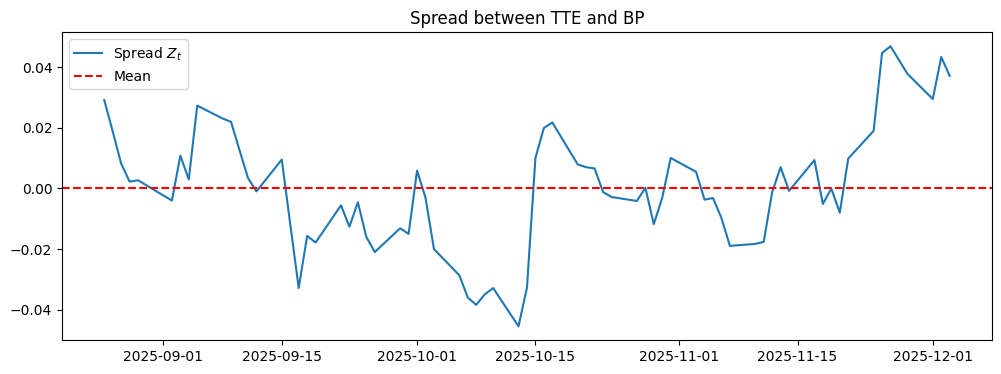

In [18]:
# Let's make sure there is a mean reversion occurs 

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Spread $Z_t$')
plt.axhline(residuals.mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread between TTE and BP')
plt.legend()
plt.show()

about every 15 days there is a mean reversion

## Model OU

### 1. Model 

**The continous time OU model :**
$$
dZ_t = \kappa(\mu - Z_t)\,dt + \sigma\,dW_t
$$


We only have discrete observations: 𝑍0,𝑍1,𝑍2,…


So we must convert the continuous-time stochastic equation into a discrete equation.

**And the discrete OU process is an AR(1) (Auto-Regressive process of order 1).**


The continuous OU → discrete OU = AR(1)

Exact solution of the OU process:

$$
Z_{t+\Delta t}
= \mu + (Z_t - \mu)e^{-\kappa \Delta t} + \varepsilon_t
$$

where

$$
\varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^{2}).
$$


We can write this equation as : 
$$
Z_{t+1} = a + b Z_t + \varepsilon_t
$$

with : 

$$
b = e^{-\kappa \Delta t}
$$

$$
a = \mu(1 - b)
$$


### 2. Estimate the parameters 

And an AR(1) model is estimated using… linear regression:

$$
Z_{t+1} = a + b Z_t + \varepsilon_t
$$

Linear regression mapping:
- Explained variable:  $Z_{t+1}$
- Explanatory variable: $Z_t$
- Intercept: $a$
- Slope: $b$


We recover the parameters of the OU process:

$$
\kappa = -\ln(b)
$$

$$
\mu = \frac{a}{1 - b}
$$

Noise standard deviation:

$$
\sigma_\varepsilon = \text{std(residuals)}
$$


In [19]:
import numpy as np
import statsmodels.api as sm

# Construire Z_t et Z_{t+1}
Z_t  = Z.iloc[:-1]   # du temps 0 à T-1
Z_t1 = Z.iloc[1:]    # du temps 1 à T



In [20]:
# verification qu'il prend bien tout en compte 
from IPython.display import display

print("=== Z_t1.tail(5) ===")
display(Z_t1.tail(5))

print("\n=== Z_t.tail(5) ===")
display(Z_t.tail(5))

print("\n=== Z_t.head(5) ===")
display(Z_t.head(5))

print("\n=== Z_t1.head(5) ===")
display(Z_t1.head(5))


=== Z_t1.tail(5) ===


Date
2025-11-26   -0.011591
2025-11-28   -0.009164
2025-12-01    0.003021
2025-12-02   -0.001987
2025-12-03    0.006546
dtype: float64


=== Z_t.tail(5) ===


Date
2025-11-25   -0.014200
2025-11-26   -0.011591
2025-11-28   -0.009164
2025-12-01    0.003021
2025-12-02   -0.001987
dtype: float64


=== Z_t.head(5) ===


Date
2025-08-25   -0.002493
2025-08-26   -0.000244
2025-08-27    0.003790
2025-08-28    0.016618
2025-08-29    0.004648
dtype: float64


=== Z_t1.head(5) ===


Date
2025-08-26   -0.000244
2025-08-27    0.003790
2025-08-28    0.016618
2025-08-29    0.004648
2025-09-02    0.006782
dtype: float64

In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# On part de ta série Z (spread) déjà calculée
Z = Z.dropna()

# Construire Z_t (observé) et Z_{t+1} (réel)
df_ou = pd.DataFrame({'Z_t': Z})
df_ou['Z_t1_real'] = df_ou['Z_t'].shift(-1)
df_ou = df_ou.dropna()  # enlève la dernière ligne

# Régression Z_{t+1} = a + b Z_t + eps
X_reg = sm.add_constant(df_ou['Z_t'])
y_reg = df_ou['Z_t1_real']

model_ou = sm.OLS(y_reg, X_reg).fit()

# ==> même vue que le 2ème code
print(model_ou.summary())

# Récupérer les paramètres avec les mêmes noms que dans ton 1er code
a = model_ou.params['const']
b = model_ou.params['Z_t']
sigma_eps = model_ou.resid.std(ddof=1)

print("a =", a)
print("b =", b)
print("sigma_eps =", sigma_eps)



                            OLS Regression Results                            
Dep. Variable:              Z_t1_real   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     205.5
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.12e-22
Time:                        15:09:46   Log-Likelihood:                 227.61
No. Observations:                  70   AIC:                            -451.2
Df Residuals:                      68   BIC:                            -446.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.103      0.9

In [22]:
# Supposons que tes données sont journalières
Delta_t = 1.0  # 1 jour; tu pourras le passer à 1/252 pour "par an" si tu veux

# 1) kappa et mu
if 0 < b < 1:
    kappa = -np.log(b) / Delta_t
else:
    kappa = np.nan
    print("⚠️ b n'est pas dans (0,1) -> mean reversion faible ou problème de données")

mu = a / (1 - b)

# 2) sigma à partir des résidus
residuals = model_ou.resid
sigma_eps = residuals.std(ddof=1)        # écart-type du bruit discret

sigma = sigma_eps * np.sqrt(2 * kappa / (1 - b**2))

print("kappa =", kappa)
print("mu    =", mu)
print("sigma =", sigma)


kappa = 0.14218437180504107
mu    = 0.0008807507999178853
sigma = 0.01011330230361921


In [23]:
df_ou['Z_hat_det'] = a + b * df_ou['Z_t']


In [24]:
np.random.seed(0)  # pour reproductibilité, optionnel

eps = np.random.normal(size=len(df_ou))
df_ou['Z_hat_stoch'] = a + b * df_ou['Z_t'] + sigma_eps * eps


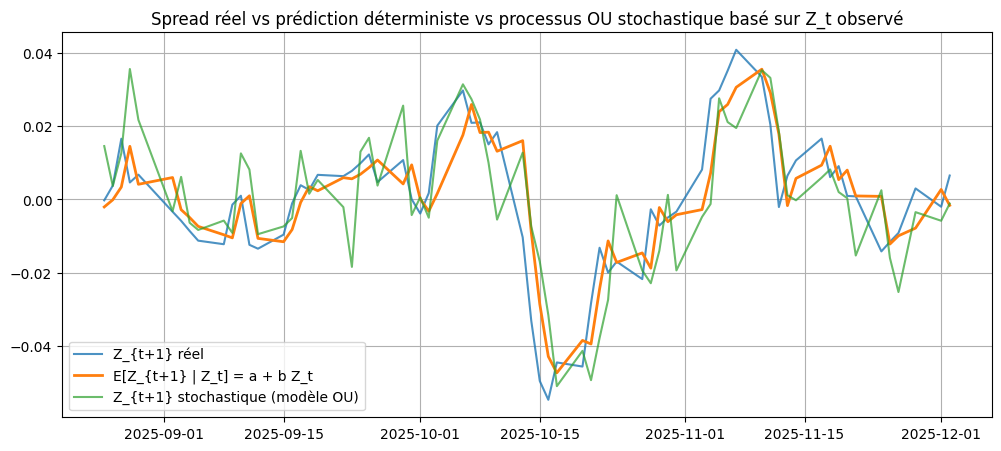

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(df_ou.index, df_ou['Z_t1_real'], label="Z_{t+1} réel", alpha=0.8)
plt.plot(df_ou.index, df_ou['Z_hat_det'], label="E[Z_{t+1} | Z_t] = a + b Z_t", linewidth=2)
plt.plot(df_ou.index, df_ou['Z_hat_stoch'], label="Z_{t+1} stochastique (modèle OU)", alpha=0.7)
plt.legend()
plt.grid(True)
plt.title("Spread réel vs prédiction déterministe vs processus OU stochastique basé sur Z_t observé")
plt.show()


We have 3 signals: 
- first one is the real spread (in blue)
- second one is the AR(1) --> discret model
- third one is the AR(1) with a noise --> stochastiq model

We keep the one with the noise.

In [26]:
### forecast for monday 1/12/2025



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dernier point observé
Z_last = Z.iloc[-1]
last_date = Z.index[-1]

print("Dernier Z observé :", Z_last, "à la date", last_date)

target_date = pd.Timestamp("2025-12-01")  # 3er décembre 2025

# Jours ouvrés entre last_date (exclu) et target_date (inclus)
bdays = pd.bdate_range(last_date + pd.Timedelta(days=1), target_date)
n_steps = len(bdays)

print("Nombre de pas (jours ouvrés) jusqu'au", target_date.date(), ":", n_steps)
print("Jours considérés :", bdays)


Dernier Z observé : 0.006546298416445495 à la date 2025-12-03 00:00:00
Nombre de pas (jours ouvrés) jusqu'au 2025-12-01 : 0
Jours considérés : DatetimeIndex([], dtype='datetime64[ns]', freq='B')


In [28]:
# On suppose que tu as déjà :
# a, b, model_ou
sigma_eps = model_ou.resid.std(ddof=1)

n_paths = 1000  # nb de scénarios pour voir la distribution au 01/12

np.random.seed(0)  # optionnel pour reproductibilité

Z_T_values = []  # stockera Z au 01/12 pour chaque scénario

for p in range(n_paths):
    Z_curr = Z_last
    for k in range(n_steps):
        eps = np.random.normal()
        Z_curr = a + b * Z_curr + sigma_eps * eps  # OU stochastique basé sur Z_t observé
    Z_T_values.append(Z_curr)

Z_T_values = np.array(Z_T_values)


In [29]:
mean_Z_T = Z_T_values.mean()
std_Z_T  = Z_T_values.std(ddof=1)
p10, p50, p90 = np.percentile(Z_T_values, [10, 50, 90])

print("Prévision stochastique pour Z au 01/12/2025 :")
print(f"  Moyenne           : {mean_Z_T:.6f}")
print(f"  Médiane           : {p50:.6f}")
print(f"  Ecart-type        : {std_Z_T:.6f}")
print(f"  Intervalle P10-P90: [{p10:.6f} ; {p90:.6f}]")


Prévision stochastique pour Z au 01/12/2025 :
  Moyenne           : 0.006546
  Médiane           : 0.006546
  Ecart-type        : 0.000000
  Intervalle P10-P90: [0.006546 ; 0.006546]


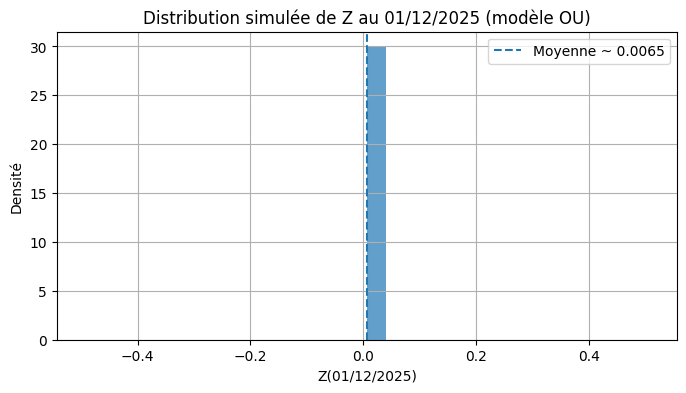

In [30]:
plt.figure(figsize=(8,4))
plt.hist(Z_T_values, bins=30, alpha=0.7, density=True)
plt.axvline(mean_Z_T, linestyle='--', label=f"Moyenne ~ {mean_Z_T:.4f}")
plt.title("Distribution simulée de Z au 01/12/2025 (modèle OU)")
plt.xlabel("Z(01/12/2025)")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()


starting from your last observed 𝑍 we :

- applying the OU dynamics
- over several simulated paths (e.g. 1000 paths)
- then taking the average at the future date you are interested in

--> IS the expected future spread according to your OU model,
--> so it is the best mathematical forecast of the future spread.


### Reminder: your discrete OU model

The calibrated model is:

##### Discrete OU model (calibrated):

$$
Z_{t+1} = a + b Z_t + \sigma_\varepsilon \varepsilon_t,
\quad \varepsilon_t \sim \mathcal{N}(0,1)
$$

with:

- $a, b$ → mean reversion and equilibrium level  
- $\sigma_\varepsilon$ → noise  
- $Z_t$ = last observed real spread (26/11)


#### We repeat this calculation over multiple scenarios (paths) $p$:

$$
Z_{t+1}^{(p)} = a + b Z_t + \sigma_\varepsilon \varepsilon_t^{(p)}
$$

Then:

$$
Z_{t+2}^{(p)} = a + b Z_{t+1}^{(p)} + \sigma_\varepsilon \varepsilon_{t+1}^{(p)}
$$

… and so on until your target date (01/12).

In the end, you obtain 1000 possible scenarios for $Z(01/12)$.


#### We then compute the forecast as:

$$
\text{Future prediction}
= \frac{1}{1000} \sum_{p=1}^{1000} Z_T^{(p)}
$$

this average is the forecast of the future spread according to your model.


#### Why is the mean the “true” forecast?

Because:

$$
\hat{Z}_{t+h} = \mathbb{E}[Z_{t+h} \mid Z_t]
$$

This is a fundamental property of the OU model.

The mean of your simulations  
equals the expected value of the spread at the future date.

Therefore, the mean of your simulated paths **is** your prediction of $Z_{\text{future}}$.



#### Close price 

- On yfinance, we obtain the close price [close]
- [adj close] is the close price without taking into account the dividend etc --> better
- The spread forecast are built based on closing price


### Test pour prédire les 3 jours suivants toujours sur 3 mois

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dernier point observé
Z_last = Z.iloc[-1]
last_date = Z.index[-1]

print("Dernier Z observé :", Z_last, "à la date", last_date)

# On veut les 3 PROCHAINS JOURS OUVRÉS à partir de last_date
n_steps = 3
bdays = pd.bdate_range(last_date + pd.Timedelta(days=1), periods=n_steps)

print("Jours considérés :", bdays)

# On suppose que tu as déjà : a, b, model_ou
sigma_eps = model_ou.resid.std(ddof=1)

n_paths = 1000  # nb de scénarios

np.random.seed(0)  # reproductibilité

# Matrice pour stocker tous les scénarios : (paths x steps)
Z_paths = np.zeros((n_paths, n_steps))

for p in range(n_paths):
    Z_curr = Z_last
    for k in range(n_steps):
        eps = np.random.normal()
        Z_curr = a + b * Z_curr + sigma_eps * eps  # OU stochastique basé sur Z_t observé
        Z_paths[p, k] = Z_curr   # valeur à l'horizon k+1 pour ce path

# Statistiques par jour (sur les 1000 scénarios)
mean_Z   = Z_paths.mean(axis=0)
std_Z    = Z_paths.std(axis=0, ddof=1)
p10, p50, p90 = np.percentile(Z_paths, [10, 50, 90], axis=0)

# Mettre tout ça dans un DataFrame pour bien voir
df_forecast = pd.DataFrame({
    "mean": mean_Z,
    "std": std_Z,
    "P10": p10,
    "P50": p50,
    "P90": p90
}, index=bdays)

print("Prévision stochastique pour les 3 prochains jours ouvrés :")
print(df_forecast)


Dernier Z observé : 0.006546298416445495 à la date 2025-12-03 00:00:00
Jours considérés : DatetimeIndex(['2025-12-04', '2025-12-05', '2025-12-08'], dtype='datetime64[ns]', freq='B')
Prévision stochastique pour les 3 prochains jours ouvrés :
                mean       std       P10       P50       P90
2025-12-04  0.005751  0.008944 -0.005706  0.005923  0.017226
2025-12-05  0.004776  0.012065 -0.010854  0.005078  0.019788
2025-12-08  0.003852  0.013763 -0.013829  0.003710  0.021487


### Test sur 2 mois


In [32]:
Z_real = Z.loc["2025-12-01":"2025-12-03"]
print(Z_real)


Date
2025-12-01    0.003021
2025-12-02   -0.001987
2025-12-03    0.006546
dtype: float64
